# <center><font color=blue>Introduction to CVX</font></center>

<center>
by Roman Schutski
<br>
16/11/2018
</center>

# Example 101

In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Create two scalar optimization variables.
x = cvx.Variable()
y = cvx.Variable()

# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

# Form objective.
obj = cvx.Minimize(cvx.square(x - y))

# Form and solve problem.
prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

status: optimal
optimal value 1.0
optimal var 1.0 1.570086213240983e-22


# Solve with audience

Maximize $-2\cdot x + 5 \cdot y$ 

subject to

$100 \leq x \leq 200$

$80 \leq y \leq 170$

$x + y \geq 200$ 

In [18]:
x = cvx.Variable()
y = cvx.Variable()

obj = cvx.Maximize(-2*x + 5*y)
constraints = [x <= 200,
               x >= 100,
               y <= 170,
               y >= 80,
               x + y >= 200]

prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)


status: optimal
optimal value 650.0
optimal var 100.0 170.0


# Conversion to standard form

In [46]:
# Setup the problem
x = cvx.Variable(2)
obj = cvx.Minimize(x[0] + cvx.norm(x, 1))
constraints = [x >= 2]
prob = cvx.Problem(obj, constraints)

# Get ECOS arguments.
data = prob.get_problem_data(cvx.ECOS)
print('Raw arguments of the solver:')
print(data[0].keys(), '\n')

# print available solvers
print('Available solvers:')
print(cvx.installed_solvers(), '\n')

# Solve the problem explicitly with CVXOPT
prob.solve(solver=cvx.ECOS)
print("optimal value with ECOS:", prob.value, '\n')


Raw arguments of the solver:
dict_keys(['c', 'offset', 'dims', 'A', 'b', 'G', 'h']) 

Available solvers:
['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'GLPK_MI', 'OSQP'] 

optimal value with ECOS: 5.999999995510096 



# In-painting problem

A grayscale image is represented as an $m \times n$ matrix of intensities $Uorig$ (typically between the values 0 and 255). We are given the values $U^{orig}_{ij}$, for $(i,j) \in K$, where $ K \in (1, .., m ) \times (1, .., n )$ is the set of indices corresponding to known pixel values. Our job is to in-paint the image by guessing the missing pixel values, i.e., those with indices not in $K$. The reconstructed image will be represented by $U \in R^{m,n}$, where $U$ matches the known pixels, i.e., $U_{ij} = U^{orig}_{ij}$ for $(i,j) \in K$

The reconstruction $U$ is found by minimizing the total variation of $U$, subject to matching the known pixel values. We will use the $l_{2}$ total variation, defined as

$tv(U) = \sum_i^{m−1} \sum_j^{n-1} \left| \begin{vmatrix} U_{i+1,j}−U_{ij} \\ U_{i,j+1}−U_{ij} \end{vmatrix} \right|_{2}$.

Note that the norm of the discretized gradient is not squared.

We load the original image and the corrupted image and construct the Known matrix. Both images are displayed below. The corrupted image has the missing pixels whited out.

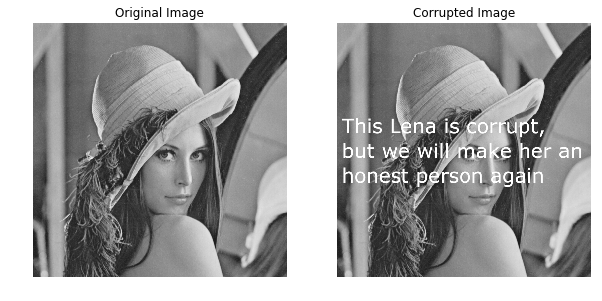

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the images.
orig_img = Image.open("lena512.bmp")
corr_img = Image.open("lena512_corrupted.bmp")


# Convert to arrays.
Uorig = np.array(orig_img)
Ucorr = np.array(corr_img)
rows, cols = Uorig.shape

# Find pixels which are definitely true
# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
Known = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
         if Uorig[i, j] == Ucorr[i, j]:
            Known[i, j] = 1

#Plot
%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(orig_img);
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted Image")
ax[1].axis('off');



### Write down the optimization problem

In [15]:
import cvxpy as cvx
U = ?

# there are handy functions in cvx module
obj = cvx.Minimize(cvx.tv(U))

constraints = ?
prob = cvx.Problem(obj, constraints)
# Use ECOS to solve the problem.
prob.solve(verbose=True, solver=cvx.ECOS)

SyntaxError: invalid syntax (<ipython-input-15-b9a566928222>, line 2)

### Show the recovered image and the difference

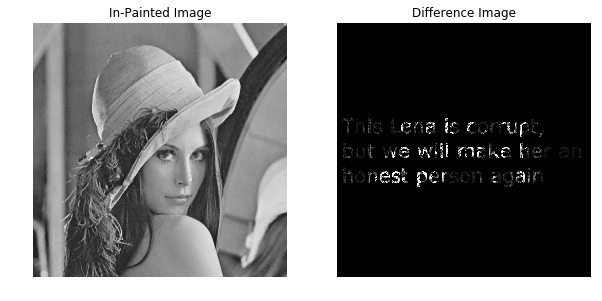

In [5]:
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
# Display the in-painted image.
img_rec = Image.fromarray(U.value)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = Image.fromarray(10*np.abs(Uorig - U.value))
ax[1].imshow(img_diff);
ax[1].set_title("Difference Image")
ax[1].axis('off');

### Extract parameters of the problem and duals

In [6]:
# Get ECOS arguments.
data = prob.get_problem_data(cvx.ECOS)
print('Raw arguments of the solver:')
print(data[0].keys(), '\n')

Raw arguments of the solver:
dict_keys(['c', 'offset', 'dims', 'A', 'b', 'G', 'h']) 



In [14]:
# Extract dual values
print("in total there are ", np.prod(constraints[0].shape), " constraints")
print("optimal dual for constraint",
    constraints[0].dual_value)


in total there are  262144  constraints
optimal dual for constraint [[-6.52160824e-09 -7.35028403e-07 -9.99999241e-01 ... -1.65266335e-08
  -5.24658956e-10  9.99999999e-01]
 [-5.84320993e-09 -7.34391692e-07 -9.99999241e-01 ... -1.65266333e-08
  -5.24659216e-10  9.99999999e-01]
 [ 2.24181795e-09 -7.26335474e-07 -9.99999240e-01 ... -1.65266333e-08
  -5.24659234e-10  9.99999999e-01]
 ...
 [ 1.99999998e+00  1.73137084e+00 -6.46952781e-01 ... -2.44721358e+00
   8.49979232e-01  3.71390675e-01]
 [-9.99998278e-01  8.58577834e-01 -2.85749292e+00 ... -1.32803690e-08
  -9.28476676e-01 -9.99999994e-01]
 [-8.95990257e-07 -6.60190510e-16 -7.33892683e-15 ...  2.37907333e-14
  -1.24776590e-14 -2.26541943e-15]]


#### Answers

In [ ]:
#U = cvx.Variable(shape=(rows, cols))
#obj = cvx.Minimize(cvx.tv(U))
#constraints = [cvx.multiply(Known, U) == cvx.multiply(Known, Ucorr)]


# Parameter usage example: LASSO

### Supporting functions
Here we define quadratic loss, create a regularizer and the full objective function

In [56]:
def loss_fn(X, Y, beta):
    return cvx.sum_squares(cvx.matmul(X, beta) - Y)
def regularizer(beta):
    return cvx.norm1(beta)
def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)
def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value


### Generate data.
Training examples and observations that are linearly related, and the relation is sparse

In [57]:
def generate_data(m=100, n=20, sigma=5, density=0.2):
    "Generates data matrix X and observations Y."
    np.random.seed(1)
    beta_star = np.random.randn(n)
    idxs = np.random.choice(range(n), int((1-density)*n), replace=False)
    for idx in idxs:
        beta_star[idx] = 0
    X = np.random.randn(m,n)
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y, beta_star

m = 100
n = 20
sigma = 5
density = 0.2

X, Y, _ = generate_data(m, n, sigma)
X_train = X[:50, :]
Y_train = Y[:50]
X_test = X[50:, :]
Y_test = Y[50:]

### Fitting the model

In [ ]:
beta = ?
lambd = ? 
problem = ? 

lambd_values = np.logspace(-2, 3, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = ?
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

### Evaluate the problem

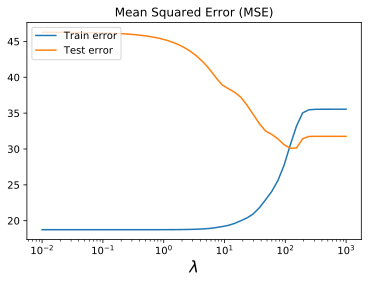

In [61]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()
    
plot_train_test_errors(train_errors, test_errors, lambd_values)



### Feature selection

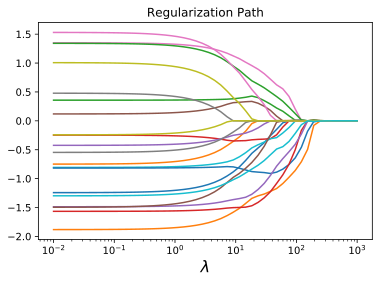

In [63]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()
    
plot_regularization_path(lambd_values, beta_values)


#### Answers

In [58]:
#beta = cvx.Variable(n)
#lambd = cvx.Parameter(nonneg=True)
#problem = cvx.Problem(cvx.Minimize(objective_fn(X_train, Y_train, beta, lambd)))
#lambd.value = v

### Parallel optimization

In [ ]:
beta = cvx.Variable(n)
lambd = cvx.Parameter(nonneg=True)
problem = cvx.Problem(cvx.Minimize(objective_fn(X_train, Y_train, beta, lambd)))

# Assign a value to lambda and find an optimal beta
def get_beta(lambda_value):
    lambd.value = lambda_value
    problem.solve()
    return beta.value
   
# Use a standard futures framework for 
# parallel execution
import concurrent.futures
train_errors = []
test_errors = []
beta_values = []

with concurrent.futures.ProcessPoolExecutor(
            max_workers=nproc) as executor:
    for beta_value in executor.map(
        get_beta, np.logspace(-2, 3, 50))
        beta_values.append(beta_value)
        train_errors.append(mse(X_train, Y_train, beta))
        test_errors.append(mse(X_test, Y_test, beta))
    